## Simple QA system

Goal is to implement a simple ML-based model that receives a question and an image and should answer the question based on the content of the image. Real-life applications for such a system could include asking an agent where to find an object in an image.

As this task is quite complex (the number of objects and questions is almost limitless), we simplify this task quite a bit: the model will have to answer questions for 3 different colors and 3 different shapes. This limits the complexity quite significantly, but nevertheless will serve as a good playground for experimenting with Deep Learning.

The shapes in the images will have different sizes and placements to force the system to learn the shapes at different sizes. The background of the images will be white to ease the task such that the system will not have to learn object detection with noisy backgrounds. A task like that would require a way larger set of training images (see [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which has over 1M classified images).
The questions and answers expected from the system are rather simple as well.

The questions all follow a common patterns:
* Does the image contain a ```<color> <shape>```?
* Is there a ```<color> <shape>```?
* Which color is in the image?
* Which shape is in the image?

The answers of the system are single words only: *'Yes', 'No', 'Green', 'Square', etc.*

As the question format is that simple and the structure of them is the same for all questions, we do not need to use an RNN/LSTM approach to parse the question or to generate the answer but instead for getting the question as input we use a simple [Bag-Of-Words (BoW) approach](https://en.wikipedia.org/wiki/Bag-of-words_model). And we return a single output: the index of the answer word. 

For that we can consider our task a **simple multi-class classification task.**

In [1]:
import os
import glob
import re

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

%matplotlib inline

### Data generation

We generate 10 images for each color/shape combination (in case we want more training data we easily can generate more). Then the images are combined with the questions and answers. 

One flaw of the system is that the system is massively skewed towards 'No' answers (see [section Answer label distribution](#Answer-label-distribution)). To overcome this bias in the data, we could add more images with questions for colors and shapes rather than 'Yes', 'No' answers.

In [2]:
IMAGE_SIZE = (50, 50)

colors = ['blue', 'red', 'green']
color_map = {
    'blue': '#0000FF',
    'red': '#FF0000',
    'green': '#00FF00'
}
shapes = ['square', 'circle', 'triangle']

def get_dimensions():
    width, height = IMAGE_SIZE
    size = np.random.randint(10, width / 2)
    left = np.random.randint(0, width - size)
    top = np.random.randint(0, height - size)
    
    return left, top, size

def draw_shape(img, color, shape):
    idraw = ImageDraw.Draw(img)
    left, top, size = get_dimensions()
    if shape is 'square':
        idraw.rectangle((left, top, left+size, top+size), fill=color_map[color])
    elif shape is 'circle':
        idraw.ellipse((left, top, left+size, top+size), fill=color_map[color])
    elif shape is 'triangle':
        idraw.polygon([(left, top+size), (left+size, top+size), (left+size/2, top)], fill=color_map[color])
    
def generate_shape_color_binary_questions(color, shape):
    questions = []
    for color2 in colors:
        for shape2 in shapes:
            questions.append((color, shape, 'Does the image contain a {} {}?'.format(color2, shape2), 'Yes' if color == color2 and shape == shape2 else 'No'))
            questions.append((color, shape, 'Is there a {} {}?'.format(color2, shape2), 'Yes' if color == color2 and shape == shape2 else 'No'))
    
    return questions

def generate_shape_binary_questions(color, shape):
    questions = []
    for shape2 in shapes:
        questions.append((color, shape, 'Does the image contain a {}?'.format(shape2), 'Yes' if shape == shape2 else 'No'))
        questions.append((color, shape, 'Is there a {}?'.format(shape2), 'Yes' if shape == shape2 else 'No'))
    
    return questions

def generate_color_binary_questions(color, shape):
    questions = []
    for color2 in colors:
        questions.append((color, shape, 'Does the image contain a {} shape?'.format(color2), 'Yes' if color == color2 else 'No'))
        questions.append((color, shape, 'Is there a {} shape?'.format(color2), 'Yes' if color == color2 else 'No'))
    
    return questions

def generate_shape_question(color, shape):
    return [
        (color, shape, 'Which color is in the image?', color)
    ]

def generate_color_question(color, shape):
    return [
        (color, shape, 'Which shape is in the image?', shape)
    ]
    
def generate_question_answer_pairs(color, shape):
    questions = []
    questions.extend(generate_shape_color_binary_questions(color, shape))
    questions.extend(generate_shape_binary_questions(color, shape))
    questions.extend(generate_color_binary_questions(color, shape))
    questions.extend(generate_shape_question(color, shape))
    questions.extend(generate_color_question(color, shape))
    
    return questions

questions = []
for shape in shapes:
    for color in colors:
        questions.extend(generate_question_answer_pairs(color, shape))
        for index in range(10):
            if not os.path.isdir('./data/{}/{}'.format(color, shape)):
                os.makedirs('./data/{}/{}'.format(color, shape))
            img = Image.new('RGB', IMAGE_SIZE, 'white') 
            draw_shape(img, color, shape)
            #img = img.rotate(45)
            img.save('./data/{}/{}/{}_{}_{}'.format(color, shape, color, shape, index) + ".jpg", "JPEG")
            #plt.imshow(img)
            #plt.show()

f = open('./data/questions.txt', 'w+')
for color, shape, question, answer in questions:
     f.write('{},{},{},{}\n'.format(color, shape, question, answer))
f.close()

In [3]:
def normalize_image(image):
    return image / 255

def load_images(color, shape):
    return [normalize_image(np.array(Image.open(path).convert('L'))) for path in glob.glob('./data/{}/{}/*.jpg'.format(color, shape))]

def load_questions(color, shape):
    data = pd.read_csv('./data/questions.txt', names=['color', 'shape', 'question', 'answer'])

    return data[(data['color'] == color) & (data['shape'] == shape)][['question', 'answer']].values
    
def load_images_and_question(color, shape):
    images = load_images(color, shape)
    questions = load_questions(color, shape)
    
    return [(image, question, answer) for image in images for (question, answer) in questions]


#for (image, question, answer) in load_images_and_question('green', 'square'):
#    plt.imshow(image)
#    plt.show()
#    print(image.shape, question, answer)

#print(np.min(load_images_and_question('red', 'square')[0][0]))
#print(np.min(load_images_and_question('green', 'square')[0][0]))
#print(np.min(load_images_and_question('blue', 'square')[0][0]))

### Data cleaning and preparation

Before vectorizing the questions and answers, we clean the data: all characters are converted to lower case and we strip characters such as ```. , ? !```. 

Both the answers and questions are converted to BoWs using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) of the sklearn library. We keep a binary flag for occurrence only, rather than really counting the number of occurrences of each word.

In our case the questions in total have 16 different words. We keep all of them (see [section Question: word corpus analysis](#Question:-word-corpus-analysis)) as the word corpus is quite small and skipping the least frequent words would cause a loss of required information: 

The least frequent word in the questions is ```color```, but as we ask which ```color``` is present in a shape now having this word in the word corpus would mean the system would not able to learn the concept of a color.

Instead of using a BoW approach, we also could have used an LSTM to process the questions. LSTMs are widely used in [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) tasks utilizing Deep Learning, such as [Machine Translation](https://towardsdatascience.com/neural-machine-translation-15ecf6b0b).
Also: instead of keeping the most frequent words of the corpus, we also could have gone for a TF-IDF related approach. TF-IDF stands for [Term Frequecy - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). There the weight of a word is calculated based on the number of occurrences of a term in a document, divided by the number of the number of documents where the word occurs. This means frequent terms such as ```the, is``` or ```a``` occur in almost all documents, thus they add very little information to understanding the context and thus have a lower weight. We could have calculated the weights of each word of the corpus and keep the one with the largest weights.

But for now, we keep all words.

In [4]:
def load_all_data():
    images_and_questions = []
    for color in colors:
        for shape in shapes:
            images_and_questions += load_images_and_question(color, shape)
            
    return pd.DataFrame(np.array(images_and_questions), columns=['image', 'question', 'answer'])

def clean_sentence(sentence):
    lowercase_sentence = sentence.lower()
    return re.sub('[?,.\-!:;]', '', lowercase_sentence)
    
data = load_all_data()

data['cleaned_question'] = data['question'].apply(lambda s : clean_sentence(s))
data['cleaned_answer'] = data['answer'].apply(lambda s : clean_sentence(s))

question_vectorizer = CountVectorizer(analyzer='word', lowercase=True, binary=True)
data['transformed_question'] = [vector.toarray()[0] for vector in question_vectorizer.fit_transform(data['cleaned_question'].values)]
answer_vectorizer = CountVectorizer(analyzer='word', lowercase=True, binary=True)
data['transformed_answer'] = [vector.toarray()[0] for vector in answer_vectorizer.fit_transform(data['cleaned_answer'].values)]

print(data.head())

                                               image  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                  question answer  \
0    Does the image contain a blue square?    Yes   
1                  Is there a blue square?    Yes   
2    Does the image contain a blue circle?     No   
3                  Is there a blue circle?     No   
4  Does the image contain a blue triangle?     No   

                         cleaned_question cleaned_answer  \
0    does the image contain a blue square            yes   
1                  is there a blue square            yes   
2    does the image contain a blue circle             no   
3                  is there a blue circle             no   
4  does the image contain a blue triangle   

### Question: word corpus analysis

Number of words: 16,
vocabulary: {'does': 4, 'the': 12, 'image': 6, 'contain': 3, 'blue': 0, 'square': 11, 'is': 8, 'there': 13, 'circle': 1, 'triangle': 14, 'red': 9, 'green': 5, 'shape': 10, 'which': 15, 'color': 2, 'in': 7}
[[1530, 'the'], [1530, 'image'], [1530, 'is'], [1350, 'does'], [1350, 'contain'], [1350, 'there'], [720, 'blue'], [720, 'square'], [720, 'circle'], [720, 'triangle'], [720, 'red'], [720, 'green'], [630, 'shape'], [180, 'which'], [180, 'in'], [90, 'color']]


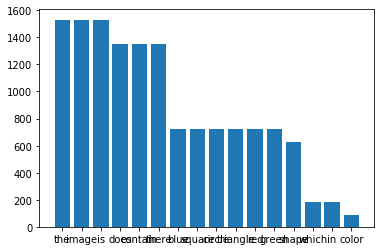

In [5]:
concatenated_questions = ' '.join(data['cleaned_question'])
question_vectorizer_2 = CountVectorizer(analyzer='word', lowercase=True)
vector = question_vectorizer_2.fit_transform([concatenated_questions]).toarray()[0]
print('Number of words: {},\nvocabulary: {}'.format(len(question_vectorizer_2.vocabulary_), question_vectorizer_2.vocabulary_))

vector_dictionary = [[vector[index], word] for (word, index) in question_vectorizer_2.vocabulary_.items()]
vector_dictionary.sort(key=lambda x : x[0], reverse=True)
print(vector_dictionary)
counts = [count for [count, _] in vector_dictionary]
words = [word for [_, word] in vector_dictionary]
plt.bar(words, counts)
plt.show()

In [6]:
print('Number of words: {},\nvocabulary: {}'.format(len(answer_vectorizer.vocabulary_), answer_vectorizer.vocabulary_))

Number of words: 8,
vocabulary: {'yes': 7, 'no': 3, 'blue': 0, 'square': 5, 'circle': 1, 'triangle': 6, 'red': 4, 'green': 2}


### Model generation

The model we are using will retrieve an image and a question and return the output label. 

As images and texts are different input types, we build a model that accepts two inputs and processes them separately. For the final decision the processing result of the image and the question are concatenated and used to return calculate the final label.

We are using [Tensorflow 2](https://www.tensorflow.org/) with the [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) to build our model.

We set up 2 different models:
* a CNN architecture to process the image
* a Feedforward Neural Network to process the BoW questions

The outputs of these 2 models are concatenated into another Feedforward NN to predict the label.

As we have a multi-class classification task, we use a [Softmax Layer](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) as the last layer of the model to normalize the outputs to have a sum of 1. Thus the output value for each class represents the probability of each class.

In [7]:
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
QUESTION_SHAPE = 16
ANSWER_SHAPE = 8

def adam_optimizer():
    return Adam(lr = 0.001, beta_1 = 0.5)

def get_image_cnn():
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_SHAPE, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    return model

def get_question_nn():
    model = Sequential()
    model.add(Dense(12, input_shape=(QUESTION_SHAPE,), activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='relu'))
    return model

def get_model():
    image_model = get_image_cnn()
    question_model = get_question_nn()
    input_image = Input(shape=IMAGE_SHAPE)
    input_question = Input(shape=(QUESTION_SHAPE,))
    
    image_result = image_model(input_image)
    question_result = question_model(input_question)
    result = concatenate([image_result, question_result])
    result = Dense(12, activation='relu')(result)
    result = Dropout(0.1)(result)
    result = Dense(ANSWER_SHAPE, activation='softmax')(result)
    model = Model(inputs=[input_image, input_question], outputs=result)
    model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return model

get_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           37232       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8)            308         input_2[0][0]                    
______________________________________________________________________________________________

### Model training

We are splitting the dataset (images with questions and answers) into a training set and a validation set. We keep 10% of all data out and use it to validate our model after training.

We train the model for 50 epochs with a batch size of 4. These two hyperparameters need to be tuned to achieve a well-fitting model that is not over-fitted to the training.

We measure the loss of the model via a [Categorical crossentropy](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy) and use the [Adam optimizer](https://arxiv.org/abs/1412.6980).

The accuracy of the model measures the percentage of correctly predicted labels. The loss the divergence of the correct label to the model prediction. As the model predicts percentages of each class and then chooses the maximum as correct label, the loss can be larger than zero even if the model makes the correct prediction.

In [8]:
# data_filtered = data[(data['answer'] == 'circle') | (data['answer'] == 'square') | (data['answer'] == 'triangle')]
# data_filtered = data[(data['answer'] == 'red') | (data['answer'] == 'green') | (data['answer'] == 'blue')]
# data_filtered = data[(data['answer'] == 'red') | (data['answer'] == 'green') | (data['answer'] == 'blue') | (data['answer'] == 'circle') | (data['answer'] == 'square') | (data['answer'] == 'triangle')]
data_filtered = data

images, questions, answers = data_filtered['image'].values, data_filtered['transformed_question'].values, data_filtered['transformed_answer'].values
images = np.array([image.reshape(IMAGE_SHAPE) for image in images])
questions = np.array([question.reshape(QUESTION_SHAPE) for question in questions])
answers = np.array([answer.reshape(ANSWER_SHAPE) for answer in answers])

train_images, test_images, train_questions, test_questions, train_answers, test_answers = train_test_split(images, questions, answers, test_size=0.1, random_state=42)

print(train_images.shape, train_questions.shape, train_answers.shape)

model = get_model()

history = model.fit([train_images, train_questions], train_answers, epochs=50, batch_size=4)

(2592, 50, 50, 1) (2592, 16) (2592, 8)
Train on 2592 samples
Epoch 1/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.8244 - accuracy: 0.7257
Epoch 2/50
2592/2592 [==============================] - 7s 3ms/sample - loss: 0.6108 - accuracy: 0.7620
Epoch 3/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.5841 - accuracy: 0.7635
Epoch 4/50
2592/2592 [==============================] - 6s 2ms/sample - loss: 0.5735 - accuracy: 0.7647
Epoch 5/50
2592/2592 [==============================] - 6s 2ms/sample - loss: 0.5664 - accuracy: 0.7658
Epoch 6/50
2592/2592 [==============================] - 7s 3ms/sample - loss: 0.5586 - accuracy: 0.7689
Epoch 7/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.5607 - accuracy: 0.7685
Epoch 8/50
2592/2592 [==============================] - 10s 4ms/sample - loss: 0.5543 - accuracy: 0.7674
Epoch 9/50
2592/2592 [==============================] - 10s 4ms/sample - loss: 0.5467 - accuracy: 0.7689
E

After training we achieve the following accuracy:

Model accuracy on non-training data (test data):
288/288 - 0s - loss: 0.1327 - accuracy: 0.9826


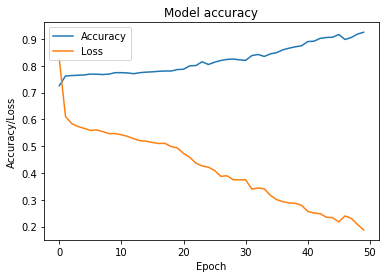

In [9]:
print('Model accuracy on non-training data (test data):')
model.evaluate([test_images, test_questions], test_answers, verbose=2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

The model achieved an accuracy (percentage of correctly predicted labels) of 98% on our testing set of examples. These were not used during the training phase and were completely new to the model. 

Thus, they are a good measure to see how the model reacts to new inputs.

### Model evaluation

To even better understand how the model performed we did a few more performance checks:
* calculating a confusion matrix to understand which classes the model is mixing up
* calculating the precision, recall and f1-scores to measure the ability of the system to avoid *False Positives* and *False Negatives*, meaning that the system does not over- or under-select the right classes.

Confusion matrix


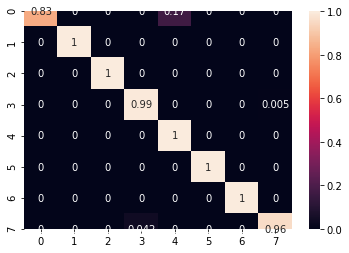

Precision: 0.9713392857142857
Recall: 0.9733270202020202
f1-score: 0.9699700665798763


In [10]:
y_pred = np.argmax(model.predict([test_images, test_questions]), axis=1)
y_test = np.argmax(test_answers, axis=1)

print('Confusion matrix')
matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()
row_sums = np.sum(matrix, axis=1)
matrix = np.around(matrix / row_sums[:,None], decimals=3)
sn.heatmap(matrix, annot=True)
plt.show()
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('f1-score:', f1_score(y_test, y_pred, average='macro'))

In the confusion matrix, we see that for most labels the model is able to predict the correct label. Only for label 0 (on the x-axis) the model has confused it with label 4 in 17% of the cases. 

When looking up the meaning of the labels:
* label 0: blue
* label 4: red

This means the model seems to have a small blue-red weakness.

The ```precision, recall``` and ```f1-score``` are measures of how well the model is able to assign the correct labels. Instead of just counting the ratio of correct labels, they also take into consideration on the False Positive and False Negative rates of the model.

Image:


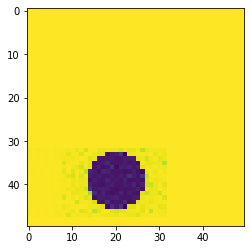

Encoded question: [0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0]
Correct answer: 3
Predicted answer: 3


In [11]:
print('Image:')
plt.imshow(test_images[0].reshape(IMAGE_SIZE))
plt.show()
print('Encoded question:', test_questions[0])
print('Correct answer:', np.argmax(test_answers[0]))
print('Predicted answer:', np.argmax(model.predict([[test_images[0]], [test_questions[0]]]), axis=1)[0])

### Answer label distribution

Test label distribution


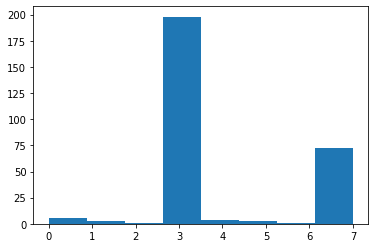

In [12]:
print('Test label distribution')
plt.hist(y_test, bins=8)
plt.show()

## Future extensions

* build a service to answer questions
* extend the domain: more colors, shapes. Add noisy images (currently we have only a little noise because of the conversion to JPEG
* playing with other model architectures & document the performance. Currently We have tuned the model in the background
 * do a systematic hyperparameter tuning process
* use transfer learning:
 * use an already trained object-detection model for "understanding" the images
 * use a pre-trained NLP-model for question understanding